# Covenant Violation and Amendment Prediction Analysis

In this notebook we will analysis on the prediction results 

There are three main steps.
1. Graphs on the results .
2. Creation of the new Violation column.
3. Analysis in the results 


In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import logging
import requests
logging.basicConfig()
logger = logging.getLogger()


import regex as re
import re

import lxml
import string


import time
import seaborn as sns



import sys
import matplotlib.pyplot as plt
#%matplotlib inline

import numpy as np

from lxml import html, etree

import dask.dataframe as dd


C:\Users\chait\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chait\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\chait\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\chait\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\chait\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\

In [2]:
model_prediction = r"C:\Users\chait\OneDrive - fs-students.de\FSFM_MADS\Master_thesis\data\model_predictions\\"

In [10]:
new_df = pd.read_parquet(model_prediction + "s3_master_final_predictions_v2.parquet")

In [11]:
new_df.to_parquet("s3_master_final_predictions_v2_pratice.parquet" , 
                  row_group_size=25000, 
                  engine="pyarrow")

In [12]:
new_df = dd.read_parquet("s3_master_final_predictions_v2_pratice.parquet")

In [13]:
new_df.npartitions

75

In [14]:
%%timeit
new_df.map_partitions(len).compute()

5.25 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [234]:
# new_df.rename(columns={'predicted_label_y':'predicted_label'}, inplace=True)

In [15]:
new_df2 = new_df[new_df['filing_type'] != '8_K']

In [16]:
# extarct the CIK number from the file path
new_df2['cik'] = new_df2['file_path'].str.split('\\').str[-1].str.split('_').str[0]


In [17]:
new_df2['cik'] = dd.to_numeric(new_df2['cik'], errors='coerce')


In [18]:
new_df2 = new_df2[~new_df2['cik'].isnull()]

In [19]:
new_df2 = new_df2.sort_values(['cik'], inplace=True)
new_df2 = new_df2.sort_values(['reporting_date'], inplace=True)

In [13]:
len(new_df2)

584417

In [ ]:
new_df2['cik'].value_counts(dropna=False).compute()

In [20]:
new_df2.columns

Index(['file_path', 'html_path', 'reporting_date', 'filing_date',
       'violation_info', 'ishtml', 'extraction_data', 'extraction_data_len',
       'filing_type', 'year', 'date_extracted', 'predicted_label',
       'extraction_data_cove', 'predicted_label_date_unfiltered', 'cik'],
      dtype='object')

In [25]:
# new_df2[ new_df2['cik'] == 1122976].compute()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,year,date_extracted,predicted_label,extraction_data_cove,predicted_label_date_unfiltered,cik
113435,F:\Master_Thesis_NLP\\sec_filings_10QK\2000\10...,https://www.sec.gov/Archives/edgar/data/112297...,2000-09-30,2000_11_14,0,True,[],0,10_Q,2000.0,None,0.0,None,0.0,1122976.0
118416,F:\Master_Thesis_NLP\\sec_filings_10QK\2000\10...,https://www.sec.gov/Archives/edgar/data/112297...,2000-12-31,2001_03_28,1_2,True,[ons of such covenants as to the court will ap...,1,10_K,2000.0,None,0.0,None,0.0,1122976.0
128642,F:\Master_Thesis_NLP\\sec_filings_10QK\2001\10...,https://www.sec.gov/Archives/edgar/data/112297...,2001-03-31,2001_05_15,0,True,[],0,10_Q,2001.0,None,0.0,None,0.0,1122976.0
134363,F:\Master_Thesis_NLP\\sec_filings_10QK\2001\10...,https://www.sec.gov/Archives/edgar/data/112297...,2001-06-30,2001_08_14,0,True,[],0,10_Q,2001.0,None,0.0,None,0.0,1122976.0
140004,F:\Master_Thesis_NLP\\sec_filings_10QK\2001\10...,https://www.sec.gov/Archives/edgar/data/112297...,2001-09-30,2001_11_14,0,True,[],0,10_Q,2001.0,None,0.0,None,0.0,1122976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282152,F:\Master_Thesis_NLP\\sec_filings_10QK\2021\10...,https://www.sec.gov/Archives/edgar/data/112297...,2021-09-30,2021_10_28,1_2,True,"[ with affiliates, create dividend or other pa...",2,10_Q,2021.0,None,0.0,None,0.0,1122976.0
1268052,F:\Master_Thesis_NLP\\sec_filings_10QK\2021\10...,https://www.sec.gov/Archives/edgar/data/112297...,2021-12-31,2022_02_22,1_2,True,[The agreements governing our Revolving Credit...,2,10_K,2021.0,None,0.0,None,0.0,1122976.0
1288756,F:\Master_Thesis_NLP\\sec_filings_10QK\2022\10...,https://www.sec.gov/Archives/edgar/data/112297...,2022-03-31,2022_04_27,1_2,True,"[ with affiliates, create dividend or other pa...",2,10_Q,2022.0,None,0.0,None,0.0,1122976.0
1293564,F:\Master_Thesis_NLP\\sec_filings_10QK\2022\10...,https://www.sec.gov/Archives/edgar/data/112297...,2022-06-30,2022_07_26,1_2,True,"[ with affiliates, create dividend or other pa...",2,10_Q,2022.0,None,0.0,None,0.0,1122976.0


In [21]:
new_df2['reporting_date_month'] = new_df2['reporting_date'].dt.month

In [ ]:
# new_df2.head()

- This approach might not work effective in this case as the filings are reported in differnt months across years . Also in few instances there are missing filings which makes even harder to guess if it is a delayed reporting or missing donwload

## New Violation and Amendment

In [32]:
# new_df2['isviolated'] = dd.where(new_df2['predicted_label']==1 , 1, 0)
# new_df2['isamended'] = dd.where(new_df2['predicted_label']==2 , 1, 0)

In [22]:
new_df2['isviolated'] = new_df2['predicted_label'].where(new_df2['predicted_label']==1 , 1)
new_df2['isviolated'] = new_df2['predicted_label'].where(new_df2['predicted_label']!=1 , 0)

In [23]:
new_df2['isamended'] = new_df2['predicted_label'].where(new_df2['predicted_label']==2 , 1)
new_df2['isamended'] = new_df2['predicted_label'].where(new_df2['predicted_label']!=2 , 0)

In [ ]:
new_df2['isamended'].value_counts().compute()

In [37]:
# new_df2[(new_df2['predicted_label']==1) & (new_df2['filing_type'] == '10_K')]['cik'].value_counts().compute()

81955.0      8
796505.0     8
727346.0     7
1121783.0    7
106455.0     7
            ..
878324.0     1
878774.0     1
879235.0     1
879303.0     1
1805385.0    1
Name: cik, Length: 1110, dtype: int64

In [24]:
new_df2 = new_df2.reset_index( drop=True)

In [25]:
def cal_new_violation(df99):
    col_pred, new_col = 'isviolated', 'new_violation'
    df99['next_10k'] =  pd.Series(df99[ (df99['filing_type'] == '10_K')].index) - pd.Series(df99[ (df99['filing_type'] == '10_K')].index).shift(1)
    df99['next_10k'] = df99['next_10k'].apply(lambda x: min(4, x))
    for val in df99[(df99['predicted_label'] == 1) & (df99['filing_type'] == '10_K')].index:
        df99.loc[val, new_col] = df99.loc[val-3:val-1, col_pred].max()
    return df99

In [26]:
def cal_new_amendment(df99):
    col_pred, new_col = 'isamended', 'new_amendment'
    df99['next_10k'] =  pd.Series(df99[ (df99['filing_type'] == '10_K')].index) - pd.Series(df99[ (df99['filing_type'] == '10_K')].index).shift(1)
    df99['next_10k'] = df99['next_10k'].apply(lambda x: min(4, x))
    for val in df99[(df99[col_pred] == 1) & (df99['filing_type'] == '10_K')].index:
        df99.loc[val, new_col] = df99.loc[val-3:val-1, col_pred].max()
    return df99

In [27]:
new_df2 = new_df2.sort_values(['cik'], inplace=True)
new_df2 = new_df2.reset_index( drop=True)
df = new_df2.groupby('cik').apply(cal_new_violation)

C:\Users\chait\AppData\Local\Temp/ipykernel_6388/4109241860.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df = new_df2.groupby('cik').apply(cal_new_violation)


In [29]:
new_df2.head()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,year,date_extracted,predicted_label,extraction_data_cove,predicted_label_date_unfiltered,cik,reporting_date_month,isviolated,isamended
0,F:\Master_Thesis_NLP\\sec_filings_10QK\1999\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1999-10-02,1999_10_26,0,False,[],0,10_Q,1999.0,None,0.0,None,0.0,20.0,10,0.0,0.0
1,F:\Master_Thesis_NLP\\sec_filings_10QK\2009\10...,https://www.sec.gov/Archives/edgar/data/20/000...,2009-01-03,2009_03_13,1_2,True,[rs were in compliance with these covenants. I...,2,10_K,2009.0,None,0.0,None,0.0,20.0,1,0.0,0.0
2,F:\Master_Thesis_NLP\\sec_filings_10QK\1998\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1998-04-04,1998_05_04,0,False,[],0,10_Q,1998.0,None,0.0,None,0.0,20.0,4,0.0,0.0
3,F:\Master_Thesis_NLP\\sec_filings_10QK\2003\10...,https://www.sec.gov/Archives/edgar/data/20/000...,2002-12-28,2003_03_27,1_2,True,[riginal term loan\nfacility and the refinance...,2,10_K,2002.0,None,0.0,None,0.0,20.0,12,0.0,0.0
4,F:\Master_Thesis_NLP\\sec_filings_10QK\1997\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1997-03-29,1997_04_30,0,False,[],0,10_Q,1997.0,None,0.0,None,0.0,20.0,3,0.0,0.0


In [32]:
df99 = new_df2.copy()


In [33]:
col_pred, new_col = 'isviolated', 'new_violation'
df99[new_col]  = 0

for val in df99[(df99['predicted_label'] == 1) & (df99['filing_type'] == '10_K')].index:
        df99.loc[val, new_col] = df99.loc[val-3:val-1, col_pred].max()
        df99[new_col] = df99[new_col].mask(new_col == 0b100, -1)

TypeError: '_LocIndexer' object does not support item assignment

In [35]:
val

47

In [51]:
new_df2.map_partitions(len).compute()

0    584416
dtype: int64

In [45]:
df.columns

Index(['file_path', 'html_path', 'reporting_date', 'filing_date',
       'violation_info', 'ishtml', 'extraction_data', 'extraction_data_len',
       'filing_type', 'year', 'date_extracted', 'predicted_label',
       'extraction_data_cove', 'predicted_label_date_unfiltered', 'cik',
       'reporting_date_month', 'isviolated', 'isamended', 'next_10k'],
      dtype='object')

In [44]:
df = df.sort_values(['cik'], inplace=True)
df = df.reset_index( drop=True)
df = df.groupby('cik').apply(cal_new_amendment)

ValueError: The columns in the computed data do not match the columns in the provided metadata
  Extra:   ['new_violation']
  Missing: []

In [ ]:
df.head().compute()

In [ ]:
df.loc[df[(df['isviolated'] == 1) & (df['filing_type'] == '10_Q') ].index, 'new_violation'] =1

In [ ]:
df.loc[df[(df['isamended'] == 1) & (df['filing_type'] == '10_Q') ].index, 'new_amendment'] = 1 

In [ ]:
# Final mapping for new violation
# the case where for a 10-k previous 10-Q are zero 
flip_index = df[(df['predicted_label']==1) &(df['new_violation']==0) & (df['filing_type'] == '10_K') ].index
df.loc[flip_index, 'new_violation'] = 1

# the case where for a 10-k previous 10-Q are 1 which means this is not a new violation
flip_index = df[(df['predicted_label']==1) & (df['new_violation']==1) & (df['filing_type'] == '10_K') ].index
df.loc[flip_index, 'new_violation'] = 0

In [ ]:
# Final mapping for new amendment
# the case where for a 10-k previous 10-Q are zero 
flip_index = df[(df['isamended']==1) & (df['new_amendment']==0) & (df['filing_type'] == '10_K') ].index
df.loc[flip_index, 'new_amendment'] = 1

# the case where for a 10-k previous 10-Q are 1 which means this is not a new violation
flip_index = df[(df['isamended']==1) & (df['new_amendment']==1) & (df['filing_type'] == '10_K') ].index
df.loc[flip_index, 'new_amendment'] = 0

In [293]:
df['new_violation'].value_counts()

1    4104
0    1626
Name: new_violation, dtype: int64

In [294]:
df['isviolated'].value_counts()

0    578650
1      5766
Name: isviolated, dtype: int64

In [296]:
df['isamended'].value_counts()

0    521273
1     63143
Name: isamended, dtype: int64

In [362]:
df['new_amendment'].value_counts()

1    54593
0     8215
Name: new_amendment, dtype: int64

In [297]:
df['predicted_label'].value_counts()

0    515507
2     63143
1      5766
Name: predicted_label, dtype: int64

In [298]:
df.shape

(584416, 21)

In [299]:
df.head()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,year,...,predicted_label,extraction_data_cove,cik,reporting_date_month,quarter_name,isviolated,isamended,next_10k,new_violation,new_amendment
0,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-03-30,1996_05_02,1_2,False,[ND RESULTS OF OPERATIONS ...,2,10_Q,1996,...,1,[],20,3,,1,0,4,1,NaN
1,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-06-29,1996_07_26,1_2,False,[PERATIONS SIX MONTHS...,2,10_Q,1996,...,1,[],20,6,,1,0,4,1,NaN
2,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-09-28,1996_10_30,1_2,False,[TIONS NINE MONTHS ENDED...,2,10_Q,1996,...,1,[],20,9,,1,0,4,1,NaN
3,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-12-28,1997_03_19,1_2,False,[ discontinuance of the Company s other Colort...,1,10_K,1996,...,1,[],20,12,,1,0,4,0,NaN
4,F:\Master_Thesis_NLP\\sec_filings_10QK\1997\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1997-03-29,1997_04_30,0,False,[],0,10_Q,1997,...,0,None,20,3,,0,0,3,NaN,NaN


In [375]:


plotly_df = df[['year', 'new_violation']].fillna(0).value_counts().to_frame('count').reset_index()

In [376]:
plotly_df[plotly_df['new_violation']==1]

,year,new_violation,count
27,2001,1,383
28,2002,1,342
29,1999,1,281
30,2009,1,259
31,2000,1,253
32,1998,1,244
33,2010,1,219
34,2003,1,216
35,1996,1,181
36,2008,1,170


In [377]:
# # Violation Plots

import plotly.express as px


fig = px.bar(plotly_df[plotly_df['new_violation']==1], 
             x="year", 
             y ='count',
             title='10Q/K Violations Count over the year',
             
              
             )




fig.update_traces(marker_color='#31417A')
fig.update_layout(  
    yaxis_title="Count of violation cases",
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    xaxis_title="Year",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
       
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<Axes: xlabel='year', ylabel='count'>

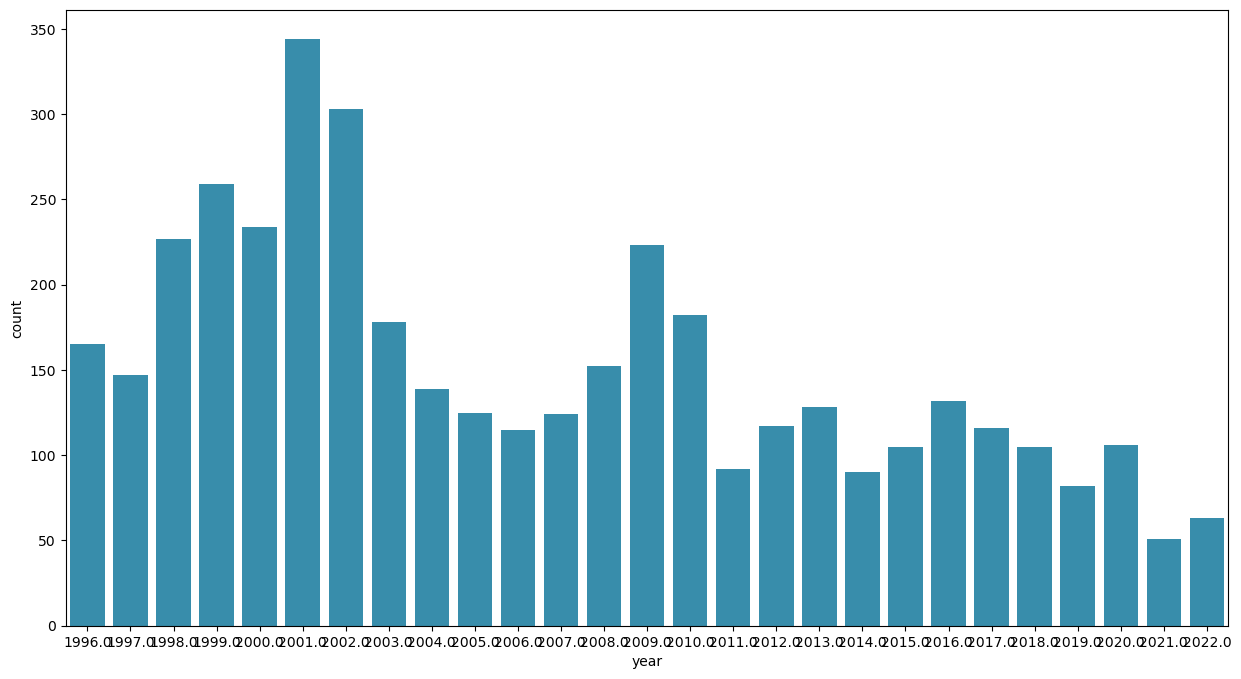

In [303]:
plt.figure(figsize=(15,8))
sns.barplot(plotly_df[plotly_df['new_violation']==1], 
             x="year", 
             y ='count',color='#2596be'
             ) #title='Count Of violations over the year'

In [363]:


plotly_df = df[['year', 'new_amendment']].fillna(0).value_counts().to_frame('count').reset_index()

In [364]:
plotly_df.head()

,year,new_amendment,count
0,1997,0,23142
1,1998,0,23052
2,1999,0,22334
3,2008,0,21940
4,2000,0,21917


In [373]:
# # Violation Plots

import plotly.express as px


fig = px.bar(plotly_df[plotly_df['new_amendment']==1], 
             x="year", 
             y ='count',
             title='10Q/K Amendment Count over the year', 
             
              
             )




fig.update_traces(marker_color='#31417A')
fig.update_layout(  
    
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
     font=dict(
        
        size=12,
        
    ),
    xaxis_title="Year",
    yaxis_title="Count of amendment cases",
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
       
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## Analyzing the 8K filings

In [479]:
new_df8 = new_df[new_df['filing_type'] == '8_K']

In [480]:
new_df8['year'].value_counts()

2006    65920
2008    65768
2007    65724
2005    65509
2010    64700
2009    64460
2011    63728
2012    63699
2013    63211
2004    60997
2014    60500
2017    59712
2020    59022
2021    58613
2018    58091
2022    57548
2019    56888
2016    56018
2003    35833
2002    27236
2001    20927
2000    17222
2015    16813
1998    16312
1999    15687
1997    14743
1996    10204
Name: year, dtype: int64

In [481]:
new_df8['dummy'] = 1

C:\Users\Madduri\AppData\Local\Temp\ipykernel_29680\1773038467.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [482]:
new_df8.columns

Index(['file_path', 'html_path', 'reporting_date', 'filing_date',
       'violation_info', 'ishtml', 'extraction_data', 'extraction_data_len',
       'filing_type', 'year', 'date_extracted', 'predicted_label',
       'extraction_data_cove', 'predicted_label_date_unfiltered', 'dummy'],
      dtype='object')

In [483]:
new_df81 = new_df8.pivot_table(index = ['year'], 
                    columns=['predicted_label'], #, 'predicted_label_date_unfiltered'
                    values='dummy', 
                    aggfunc=np.sum ,margins=True,margins_name='record_total').iloc[:-1,:]

In [484]:
new_df81.reset_index(inplace=True)

In [485]:
new_df81

predicted_label,year,0.0,1.0,2.0,record_total
0,1996,9994,22,188,10204
1,1997,14499,34,210,14743
2,1998,16001,45,266,16312
3,1999,15355,31,301,15687
4,2000,16897,38,287,17222
5,2001,20494,41,392,20927
6,2002,26732,44,460,27236
7,2003,35347,57,429,35833
8,2004,60336,44,617,60997
9,2005,64760,30,719,65509


In [486]:
new_df81.columns

Index(['year', 0.0, 1.0, 2.0, 'record_total'], dtype='object', name='predicted_label')

In [386]:
import plotly.graph_objects as go


# Create the figure object and specify the layout
fig = go.Figure()



# Line Plot


fig.add_trace( 
    go.Scatter(       x=new_df81['year'], 
                      y=new_df81['record_total'], 
                     #   mode='lines', 
                        #name='Total files'
              )
            )

# Bar Plot
fig.add_trace( 
        go.Bar(
                  x=new_df81["year"], 
                     y=new_df81[1.0]
                     )
        )


fig.update_layout(title='8K violations count over the year', 
                  xaxis_title='Date', 
                  yaxis_title='Violation Count')

# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)
# Show the plot
fig.show()

In [387]:
# import seaborn 
# seaborn.lineplot(new_df_4.sample(100), x='reporting_date', y='predicted_label' )
import plotly.graph_objects as go



import plotly.express as px

fig = px.line(x=new_df81['year'], 
              y=new_df81['record_total'], 
              
             labels=dict(x="year", y="record_total"))


fig = px.bar(new_df81, 
             x="year", 
             y=1.0, 
             title='8K violations count over the year',
              
             )
fig.show()

In [435]:
# # Violation Plots

import plotly.express as px


fig = px.bar(new_df81, 
             x="year", 
             y =1,
             title='8-k Violation count over the year',        
             )


fig.update_traces(marker_color='#31417A')
fig.update_layout(  
    
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
     font=dict(
        
        size=12,
        
    ),
    xaxis_title="Year",
    yaxis_title="Count of Violation cases",
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
       
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<Axes: xlabel='year', ylabel='count'>

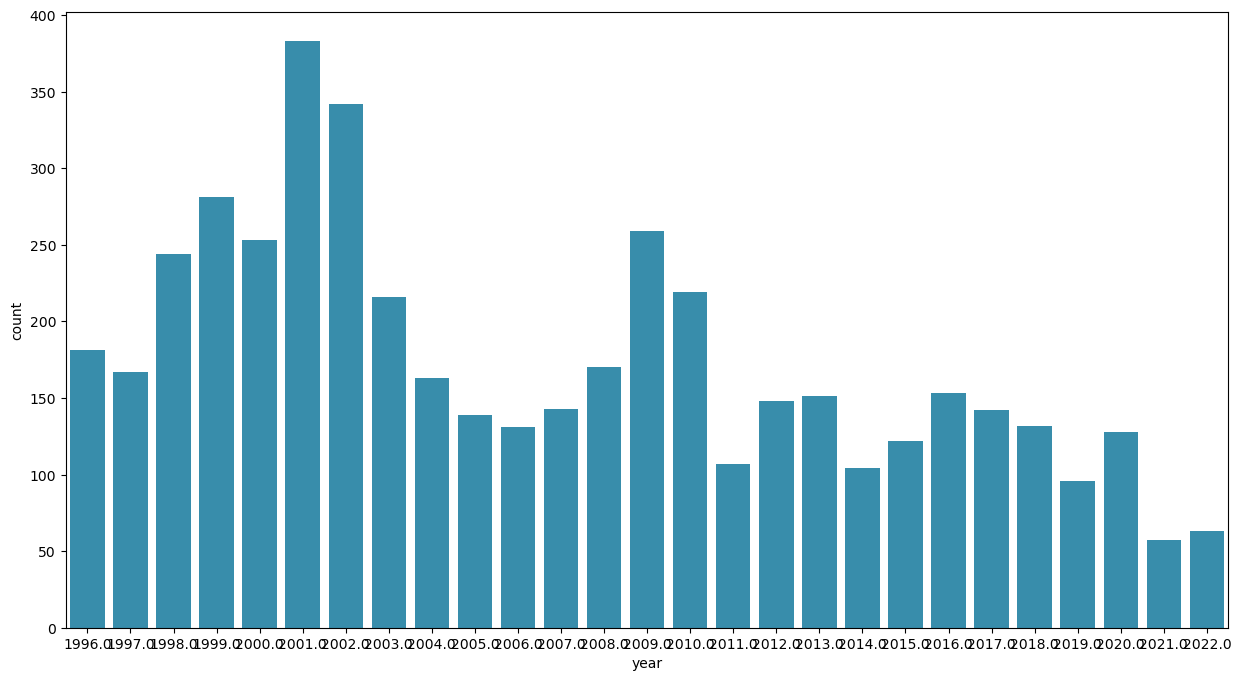

In [436]:
plt.figure(figsize=(15,8))
sns.barplot(plotly_df[plotly_df['new_violation']==1], 
             x="year", 
             y ='count',color='#2596be'
             ) #title='Count Of violations over the year'

In [437]:
# # Violation Plots

import plotly.express as px


fig = px.bar(new_df81, 
             x="year", 
             y =2,
             title='8-k amendment count over the year',        
             )


fig.update_traces(marker_color='#31417A')
fig.update_layout(  
    
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
     font=dict(
        
        size=12,
        
    ),
    xaxis_title="Year",
    yaxis_title="Count of Amendment cases",
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
       
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## Analyzing the 8K filings with unfiltered predicted labels

In [487]:
new_df82= new_df8.pivot_table(index = ['year'], 
                    columns=['predicted_label_date_unfiltered'], #, 'predicted_label_date_unfiltered'
                    values='dummy', 
                    aggfunc=np.sum ,margins=True,margins_name='record_total').iloc[:-1,:]

In [488]:
new_df82.reset_index(inplace=True)
new_df82.head()

predicted_label_date_unfiltered,year,0.0,1.0,2.0,record_total
0,1996,9864,21,319,10204
1,1997,14287,37,419,14743
2,1998,15818,55,439,16312
3,1999,15192,39,456,15687
4,2000,16700,49,473,17222


In [489]:
new_df82.columns = ['year', 'unfilter_0', 'unfilter_1', 'unfilter_2', 'record_total']

In [490]:
new_df8_final = pd.concat([new_df81, new_df82[['unfilter_0', 'unfilter_1', 'unfilter_2']]], axis=1)

In [491]:
new_df8_final

,year,0.0,1.0,2.0,record_total,unfilter_0,unfilter_1,unfilter_2
0,1996,9994,22,188,10204,9864,21,319
1,1997,14499,34,210,14743,14287,37,419
2,1998,16001,45,266,16312,15818,55,439
3,1999,15355,31,301,15687,15192,39,456
4,2000,16897,38,287,17222,16700,49,473
5,2001,20494,41,392,20927,20301,52,574
6,2002,26732,44,460,27236,26546,51,639
7,2003,35347,57,429,35833,35182,66,585
8,2004,60336,44,617,60997,60041,61,895
9,2005,64760,30,719,65509,64497,35,977


In [502]:
new_df8_final['amend_diff'] = new_df8_final['unfilter_2'] - new_df8_final[2]
new_df8_final['violation_diff'] = new_df8_final['unfilter_1'] - new_df8_final[1]

In [504]:
new_df8_final.describe()

,year,0.0,1.0,2.0,record_total,unfilter_0,unfilter_1,unfilter_2,amend_diff,violation_diff
count,27,27,27,27,27,27,27,27,27,27
mean,2009,47131,29,436,47596,46932,35,629,193,6
std,8,20796,16,180,20917,20765,18,235,62,4
min,1996,9994,4,104,10204,9864,4,153,49,-1
25%,2002,23613,18,304,24082,23424,21,450,154,3
50%,2009,58276,28,397,58613,58145,35,574,179,5
75%,2016,63170,38,536,63714,62930,48,790,254,8
max,2022,65231,71,853,65920,64943,77,1150,297,17


In [505]:
new_df8_final.sum()

year               54243
0.0              1272533
1.0                  780
2.0                11772
record_total     1285085
unfilter_0       1267175
unfilter_1           933
unfilter_2         16977
amend_diff          5205
violation_diff       153
dtype: float64

In [500]:
# # Violation Plots

import plotly.express as px
import plotly.graph_objects as go

# fig = px.bar(new_df81, 
#              x="year", 
#              y =[2,'unfilter_2'],
#              title='8-k amendment count over the year',        
#              )


# fig = go.Figure(data=[
#     go.Bar(name='filan Predictions', x="year", y=2),
#     go.Bar(name='unfiltered Precitions', x="year", y='unfilter_2')
# ])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=new_df8_final["year"],
    y=new_df8_final[2],
    name='Primary Product',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=new_df8_final["year"],
    y=new_df8_final['unfilter_2'],
    name='Secondary Product',
    marker_color='lightsalmon'
))





# fig.update_traces(marker_color='#31417A')
fig.update_layout(  
    
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
     font=dict(
        
        size=12,
        
    ),
    xaxis_title="Year",
    yaxis_title="Count of Amendment cases",
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
       
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [501]:
# # Violation Plots

import plotly.express as px
import plotly.graph_objects as go

# fig = px.bar(new_df81, 
#              x="year", 
#              y =[2,'unfilter_2'],
#              title='8-k amendment count over the year',        
#              )


# fig = go.Figure(data=[
#     go.Bar(name='filan Predictions', x="year", y=2),
#     go.Bar(name='unfiltered Precitions', x="year", y='unfilter_2')
# ])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=new_df8_final["year"],
    y=new_df8_final[1],
    name='Primary Product',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=new_df8_final["year"],
    y=new_df8_final['unfilter_1'],
    name='Secondary Product',
    marker_color='lightsalmon'
))





# fig.update_traces(marker_color='#31417A')
fig.update_layout(  
    
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
     font=dict(
        
        size=12,
        
    ),
    xaxis_title="Year",
    yaxis_title="Count of Amendment cases",
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
       
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [509]:
new_df8[new_df8['predicted_label'] != new_df8['predicted_label_date_unfiltered']].sample(20).to_csv("filter_correction_iumpact.csv")

## checking teh model performance th 40 8K files

In [397]:
new_df8_valid = pd.concat([new_df8[new_df8['predicted_label']==1].sample(20), 
                          new_df8[new_df8['predicted_label']==2].sample(20)])

In [402]:
new_df8_valid.to_excel('85_validation_sample.xlsx', index=None)

In [408]:
new_df8_valid = pd.read_excel('85_validation_sample.xlsx')

In [409]:
new_df8_valid.head()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,year,date_extracted,predicted_label,extraction_data_cove,manual_label,dummy,Unnamed: 15
0,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\8_...,https://www.sec.gov/Archives/edgar/data/878897...,1996-09-30,1996_09_23,1_2,False,"["" ownership interest back to PPC for a nomina...",1,8_K,1996,"['February 1, 1996']",1,['net worth'],1,1,NaN
1,F:\Master_Thesis_NLP\\sec_filings_10QK\2008\8_...,https://www.sec.gov/Archives/edgar/data/778164...,2008-03-26,2008_03_27,1_2,True,['me aware of various events or circumstances ...,1,8_K,2008,"['December 31, 2007']",1,[],1,1,NaN
2,F:\Master_Thesis_NLP\\sec_filings_10QK\2000\8_...,https://www.sec.gov/Archives/edgar/data/109570...,2000-07-20,2000_07_20,1_2,False,"[' 1998, the Predecessor Company has not b...",1,8_K,2000,['1998'],1,['work capital'],1,1,NaN
3,F:\Master_Thesis_NLP\\sec_filings_10QK\2012\8_...,https://www.sec.gov/Archives/edgar/data/921768...,2012-03-13,2012_03_16,1_2,True,"['g. As previously disclosed, the Court of Cha...",1,8_K,2012,"['November 1, 2011']",1,[],1,1,NaN
4,F:\Master_Thesis_NLP\\sec_filings_10QK\2002\8_...,https://www.sec.gov/Archives/edgar/data/111352...,2002-08-14,2002_10_21,1_2,False,[' Page 2 ...,1,8_K,2002,['third quarter'],1,[],1,1,NaN


In [410]:
new_df8_valid[['manual_label','predicted_label']]

,manual_label,predicted_label
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [414]:
# Violation class 
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
accuracy_score(new_df8_valid['manual_label'].iloc[:20], new_df8_valid['predicted_label'].iloc[:20] )

0.95

In [415]:
# amendment class 
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
accuracy_score(new_df8_valid['manual_label'].iloc[20:], new_df8_valid['predicted_label'].iloc[20:] )

0.7

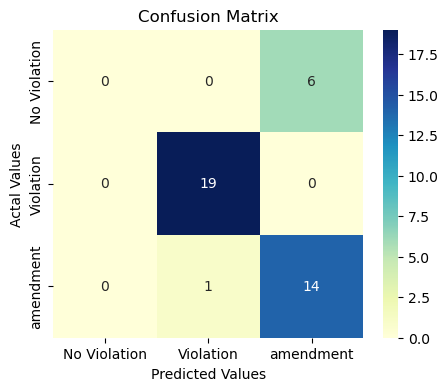

In [412]:
import matplotlib.pyplot as plt
import seaborn as sns
cnf_matrix = confusion_matrix(new_df8_valid['manual_label'], new_df8_valid['predicted_label'] )
#Plotting the confusion matrix

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cnf_matrix,
                     index = ['No Violation','Violation','amendment'], 
                     columns = ['No Violation','Violation','amendment'])
plt.figure(figsize=(5,4))

sns.heatmap(cm_df, annot=True,  cmap="YlGnBu",  fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [525]:
df.to_parquet(model_prediction + "s4_new_violation_amend_10QK.parquet")

## Plots 

- Year which previaled the maximium violations - The graphs above show case this 
- Company secific violation 


### Yealy disturbution of the number of files 

In [511]:
df23 = pd.read_excel(r"C:\Users\Madduri\OneDrive - fs-students.de\FSFM_MADS\Master_thesis\data\extarction_stats.xlsx")

In [512]:
df23.head()

,year,10_k,10_q,8_k,8_k_2,8_k_3,8_k_4,All
0,1996,1111,21289,9665,1885,0,0,33950
1,1997,4524,20180,13944,2009,0,1,40658
2,1998,4524,20319,15614,1994,0,0,42451
3,1999,4443,20073,15052,1939,0,0,41507
4,2000,4366,19885,16405,2022,0,0,42678


In [513]:
df23['8_k_whole'] = df23['8_k'] + df23['8_k_2'] + df23['8_k_3'] + df23['8_k_4']

In [515]:
df23.head()

,year,10_k,10_q,8_k,8_k_2,8_k_3,8_k_4,All,8_k_whole
0,1996,1111,21289,9665,1885,0,0,33950,11550
1,1997,4524,20180,13944,2009,0,1,40658,15954
2,1998,4524,20319,15614,1994,0,0,42451,17608
3,1999,4443,20073,15052,1939,0,0,41507,16991
4,2000,4366,19885,16405,2022,0,0,42678,18427


In [524]:
# # Violation Plots

import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df23["year"],
    y=df23['10_k'],
    name='10-K',
    mode='lines+markers',
    marker_color='#31417a'
))
fig.add_trace(go.Scatter(
    x=df23["year"],
    y=df23['10_q'],
    name='10-Q',
    mode='lines+markers',
    marker_color='#266399'
))

fig.add_trace(go.Scatter(
    x=df23["year"],
    y=df23['8_k_whole'],
    name='8-K',
    mode='lines+markers',
    marker_color='#1595c6'
))




# fig.update_traces(marker_color='#31417A')
fig.update_layout(  
     
    font_family="Times New Roman",    
    title_font_family="Times New Roman",
    
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
     font=dict(
        
        size=12,
        
    ),
    xaxis_title="Year",
    yaxis_title="No of files",
    plot_bgcolor='#f2f2f2',  # Gray background color,
    title={
     'text':"Yearly count of filings",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### SIC wise covenant violation 

In [526]:
df.head()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,year,...,predicted_label,extraction_data_cove,cik,reporting_date_month,quarter_name,isviolated,isamended,next_10k,new_violation,new_amendment
0,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-03-30,1996_05_02,1_2,False,[ND RESULTS OF OPERATIONS ...,2,10_Q,1996,...,1,[],20,3,,1,0,4,1,NaN
1,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-06-29,1996_07_26,1_2,False,[PERATIONS SIX MONTHS...,2,10_Q,1996,...,1,[],20,6,,1,0,4,1,NaN
2,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-09-28,1996_10_30,1_2,False,[TIONS NINE MONTHS ENDED...,2,10_Q,1996,...,1,[],20,9,,1,0,4,1,NaN
3,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1996-12-28,1997_03_19,1_2,False,[ discontinuance of the Company s other Colort...,1,10_K,1996,...,1,[],20,12,,1,0,4,1,NaN
4,F:\Master_Thesis_NLP\\sec_filings_10QK\1997\10...,https://www.sec.gov/Archives/edgar/data/20/000...,1997-03-29,1997_04_30,0,False,[],0,10_Q,1997,...,0,None,20,3,,0,0,3,NaN,NaN


In [530]:
data_folder = r"C:\Users\Madduri\OneDrive - fs-students.de\FSFM_MADS\Master_thesis\data\\"

# the input file 
select_cik = pd.read_csv(data_folder + "Fundamentals_quarterly94-22.csv")

In [531]:
select_cik.shape

(854915, 20)

In [532]:
select_cik.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,curcdq,datacqtr,datafqtr,atq,cshoq,saleq,cik,costat,prccq,sic
0,1004,19960229,1995,3,INDL,C,D,STD,AIR,AAR CORP,USD,1996Q1,1995Q3,429,16,136,1750,A,20,5080
1,1004,19960531,1995,4,INDL,C,D,STD,AIR,AAR CORP,USD,1996Q2,1995Q4,438,16,138,1750,A,22,5080
2,1004,19960831,1996,1,INDL,C,D,STD,AIR,AAR CORP,USD,1996Q3,1996Q1,450,16,136,1750,A,22,5080
3,1004,19961130,1996,2,INDL,C,D,STD,AIR,AAR CORP,USD,1996Q4,1996Q2,469,16,136,1750,A,30,5080
4,1004,19970228,1996,3,INDL,C,D,STD,AIR,AAR CORP,USD,1997Q1,1996Q3,524,18,154,1750,A,26,5080


In [533]:
select_cik = select_cik[['cik','sic']].drop_duplicates() 

In [537]:
df = df.merge(select_cik, how='left')

In [538]:
df.sic.value_counts()

6020    45517
2836    26294
6798    21931
7370    21758
7372    20496
        ...  
4961       16
8600       16
5064       14
4900        9
5271        2
Name: sic, Length: 443, dtype: int64

In [539]:
df_sic = pd.read_excel(data_folder + "sic_info.xlsx")

In [544]:
df_sic[['SIC_range_start','SIC_range_end']] = df_sic['SIC_range'].str.split('-', 1, expand=True)

C:\Users\Madduri\AppData\Local\Temp\ipykernel_29680\3942156032.py:1: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.



In [545]:
df_sic

,SIC_range,Classification,SIC_range_start,SIC_range_end
0,0100-0999,"Agriculture, forestry and fishing",0100,0999
1,1000-1499,Mining,1000,1499
2,1500-1799,Construction,1500,1799
3,2000-3999,Manufacturing,2000,3999
4,4000-4999,"Transportation, communications, electric, gas ...",4000,4999
5,5000-5199,Wholesale trade,5000,5199
6,5200-5999,Retail trade,5200,5999
7,6000-6799,"Finance, insurance and real estate",6000,6799
8,7000-8999,Services,7000,8999


In [557]:
df_sic['SIC_range_start'] = df_sic['SIC_range_start'].astype(int)
df_sic['SIC_range_end'] = df_sic['SIC_range_end'].astype(int)

In [552]:
comp_sic = pd.DataFrame(df.sic.unique(), columns=['SIC'])

In [555]:
comp_sic['SIC'] = comp_sic['SIC'].fillna(0).astype(int)

In [576]:
comp_sic['SIC_class'] = ''

In [589]:
for class_name  in df_sic['Classification'].unique():
    sl = df_sic[df_sic['Classification'] == class_name]
    comp_sic['SIC_class'] = np.where(comp_sic['SIC'].between(sl['SIC_range_start'].values[0], sl['SIC_range_end'].values[0]), 
                                                             class_name, 
                                                             comp_sic['SIC_class'])

In [590]:
comp_sic['SIC']

0      3823
1      5080
2      2670
3      3845
4      8700
       ... 
439    8600
440    8900
441    2092
442    6022
443    4900
Name: SIC, Length: 444, dtype: int32

In [591]:
comp_sic

,SIC,SIC_class
0,3823,Manufacturing
1,5080,Wholesale trade
2,2670,Manufacturing
3,3845,Manufacturing
4,8700,Services
...,...,...
439,8600,Services
440,8900,Services
441,2092,Manufacturing
442,6022,"Finance, insurance and real estate"


In [604]:
comp_sic['SIC_class'].value_counts(dropna=False)

Manufacturing                                                         217
Services                                                               62
Finance, insurance and real estate                                     39
Transportation, communications, electric, gas and sanitary service     36
Wholesale trade                                                        33
Retail trade                                                           30
Mining                                                                 11
Construction                                                            7
Agriculture, forestry and fishing                                       5
                                                                        4
Name: SIC_class, dtype: int64

In [594]:
df = df.merge(comp_sic, 
         how='left', 
         left_on = 'sic', 
         right_on = 'SIC')

In [607]:
df['SIC_class'].value_counts(dropna=False)

Manufacturing                                                         220536
Finance, insurance and real estate                                    128357
Services                                                              100002
Transportation, communications, electric, gas and sanitary service     42913
Retail trade                                                           30758
Mining                                                                 28326
Wholesale trade                                                        17338
                                                                        7973
Construction                                                            6155
Agriculture, forestry and fishing                                       2011
0                                                                         47
Name: SIC_class, dtype: int64

In [609]:
df['SIC_class'].unique()

array(['Manufacturing', 'Wholesale\xa0trade', 'Services', 'Construction',
       'Transportation, communications, electric, gas and sanitary service',
       'Finance,\xa0insurance\xa0and\xa0real estate', 'Retail\xa0trade',
       'Agriculture,\xa0forestry\xa0and\xa0fishing', 'Mining', '', 0],
      dtype=object)

In [614]:
df['SIC_class'] = np.where(df['SIC_class'] == '', 'others', df['SIC_class'])
df['SIC_class'] = np.where(df['SIC_class'] == 0, 'others', df['SIC_class'])

In [648]:
from IPython.display import display
pd.options.display.float_format = '{:,.4f}'.format

In [643]:
df.fillna(0, inplace=True)

In [649]:
summary_sic = df.pivot_table(index=['SIC_class'], 
                             values=['new_violation','new_amendment'], 
                             aggfunc=np.sum)

In [650]:
summary_sic.reset_index(inplace=True)

In [651]:
summary_sic['new_amendment'] = summary_sic['new_amendment']/summary_sic['new_amendment'].sum()
summary_sic['new_violation'] = summary_sic['new_violation']/summary_sic['new_violation'].sum()

In [636]:
pd.set_option('display.precision', 2)

In [655]:
summary_sic

,SIC_class,new_amendment,new_violation
0,"Agriculture, forestry and fishing",0.0039,0.0023
1,Construction,0.0155,0.0173
2,"Finance, insurance and real estate",0.1105,0.1472
3,Manufacturing,0.4088,0.3873
4,Mining,0.0536,0.0673
5,Retail trade,0.0685,0.0530
6,Services,0.2036,0.1866
7,"Transportation, communications, electric, gas ...",0.0865,0.0859
8,Wholesale trade,0.0406,0.0394
9,others,0.0085,0.0136


In [654]:
summary_sic.to_excel("SIC_summary.xlsx", index=False)

# Appendix
## Company Specific analysis

### List the companies based on the violation and amendment count

In [504]:
## Violations
new_df2[(new_df2['predicted_label']==1)]['cik'].value_counts()

1287750    71
1326003    53
1476765    47
1019849    44
784539     42
           ..
904901      1
901077      1
900091      1
899597      1
1850079     1
Name: cik, Length: 2342, dtype: int64

In [500]:
new_df2[(new_df2['predicted_label']==1) & (new_df2['cik'] == 1287750)].head()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,predicted_label,year,date_extracted,extraction_data_cove,cik,reporting_date_month,isviolated,isamended
468222,F:\Master_Thesis_NLP\\sec_filings_10QK\2004\10...,https://www.sec.gov/Archives/edgar/data/128775...,2004-12-31,2005_03_30,1_2,True,[rming as expected and the risk factors are ne...,2,10_K,1,2004,[],[],1287750,12,1,0
468223,F:\Master_Thesis_NLP\\sec_filings_10QK\2005\10...,https://www.sec.gov/Archives/edgar/data/128775...,2005-03-31,2005_05_04,1_2,True,[rming as expected and the risk factors are ne...,2,10_Q,1,2005,[],[],1287750,3,1,0
468224,F:\Master_Thesis_NLP\\sec_filings_10QK\2005\10...,https://www.sec.gov/Archives/edgar/data/128775...,2005-06-30,2005_08_08,1_2,True,[rming as expected and the risk factors are ne...,2,10_Q,1,2005,[],[],1287750,6,1,0
468225,F:\Master_Thesis_NLP\\sec_filings_10QK\2005\10...,https://www.sec.gov/Archives/edgar/data/128775...,2005-09-30,2005_11_14,1_2,True,[rming as expected and the risk factors are ne...,2,10_Q,1,2005,[],[],1287750,9,1,0
468226,F:\Master_Thesis_NLP\\sec_filings_10QK\2005\10...,https://www.sec.gov/Archives/edgar/data/128775...,2005-12-31,2006_02_28,1_2,True,[rming as expected and the risk factors are ne...,2,10_K,1,2005,"[December 31, 2005]",[],1287750,12,1,0


In [506]:
new_df2[(new_df2['predicted_label']==1) & (new_df2['cik'] == 1476765)]['extraction_data'].values

array([array(['Involves\n      a borrower performing below expectations and indicates that the loan’s\n      risk has increased somewhat since origination. The borrower may be out of\n      compliance with debt covenants; however; loan payments are generally not\n      past due. ',
              'Involves\n      a borrower performing materially below expectations and indicates that the\n      loan’s risk has increased materially since origination. In addition to the\n      borrower being generally out of compliance with debt covenants, loan\n      payments may be past due (but generally not more than 180 days past due).\n      For loans graded 2, we will implement a plan to increase monitoring of the\n      borrower. ',
              'Indicates\n      that the borrower is performing substantially below expectations and the\n      loan risk has substantially increased since origination. Most or all of\n      the debt covenants are out of compliance and payments are substantially\n      

- In the above case after the close look into the filing we have realised that it is a disclamier or just for information and it is not actual covenant annoucment.

CIK checked :
- 1326003
- 1287750

In [505]:
new_df2[(new_df2['predicted_label']==1) & (new_df2['cik'] == 1326003)]['extraction_data'].values

array([array(['assessment of success of the portfolio company in adhering to its business plan and compliance with covenants; ',
              ' Investments in portfolio companies whose performance is below the Advisor\x92s expectations\nand for which risk has increased materially since origination. Some loss of investment return is expected, but no loss of principal is expected. Companies graded 3 will generally be out of compliance with debt covenants and will be unlikely to make\ndebt repayments on their original schedule. As of December\xa031, 2006, the Advisor rated approximately 2% of our portfolio companies representing approximately 2% of the value of our total investments as Grade 3. ',
              'At December\xa031, 2006, the Company was in compliance with all financial and operational covenants required by the Credit Agreement. '],
             dtype=object)                                                                                                                    

In [16]:
new_df2_para = pd.read_parquet(model_prediction + "s3_master_final_paragraph_predictions.parquet")

In [17]:
# extarct the CIK number from the file path
new_df2_para['cik'] = new_df2_para['file_path'].str.split('\\').str[-1].str.split('_').str[0]
new_df2_para['cik'] = pd.to_numeric(new_df2_para['cik'], errors='coerce')
new_df2_para.sort_values(['cik','reporting_date'], inplace=True)

In [18]:
new_df2_para[new_df2_para['html_path'] == new_df2[(new_df2['predicted_label']==1) & (new_df2['cik'] == 1476765)]['html_path'].values[0]]

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,predicted_label,filing_type,date_extracted,extraction_data_cove,cik
215152,F:\Master_Thesis_NLP\\sec_filings_10QK\2010\10...,https://www.sec.gov/Archives/edgar/data/147676...,2010-03-31,2010_05_13,1_2,True,Involves\n a borrower performing below ex...,3,1,10_Q,,[],1476765
215153,F:\Master_Thesis_NLP\\sec_filings_10QK\2010\10...,https://www.sec.gov/Archives/edgar/data/147676...,2010-03-31,2010_05_13,1_2,True,Indicates\n that the borrower is performi...,3,1,10_Q,,[],1476765


In [19]:
new_df2_para[new_df2_para['html_path'] == new_df2[(new_df2['predicted_label']==1) & (new_df2['cik'] == 1476765)]['html_path'].values[0]]['extraction_data'].values

array(['Involves\n      a borrower performing below expectations and indicates that the loan’s\n      risk has increased somewhat since origination. The borrower may be out of\n      compliance with debt covenants; however; loan payments are generally not\n      past due. ',
       'Indicates\n      that the borrower is performing substantially below expectations and the\n      loan risk has substantially increased since origination. Most or all of\n      the debt covenants are out of compliance and payments are substantially\n      delinquent. Loans graded 1 are not anticipated to be repaid in full and we\n      will reduce the fair market value of the loan to the amount\xa0we\n      anticipate will be recovered. '],
      dtype=object)

In [521]:
new_df2_para[new_df2_para['cik'] ==  1476765]['extraction_data'].values

array(['Involves\n      a borrower performing below expectations and indicates that the loan’s\n      risk has increased somewhat since origination. The borrower may be out of\n      compliance with debt covenants; however; loan payments are generally not\n      past due. ',
       'Indicates\n      that the borrower is performing substantially below expectations and the\n      loan risk has substantially increased since origination. Most or all of\n      the debt covenants are out of compliance and payments are substantially\n      delinquent. Loans graded 1 are not anticipated to be repaid in full and we\n      will reduce the fair market value of the loan to the amount\xa0we\n      anticipate will be recovered. ',
       'Involves\n      a borrower performing below expectations and indicates that the loan’s\n      risk has increased somewhat since origination. The borrower may be out of\n      compliance with debt covenants; however; loan payments are generally not\n      past due.'

In [529]:
new_df2_para[(new_df2_para['predicted_label'] ==  1) & (new_df2_para['date_extracted']!= '')]['extraction_data'].values

array(['ND RESULTS OF OPERATIONS                        THREE MONTHS ENDED MARCH 30, 1996  Overview - --------       As reported in the Company s Annual Report on Form 10-K for the fiscal year ended December 30, 1995, the Company and its U.S.  manufacturing subsidiary are in default under several financial covenants contained in their loan agreement with three U.S.  banks, and the Company s Swiss manufacturing subsidiary is in violation of certain equity guarantees contained in its loan agreements with several Swiss lenders, resulting in a default under each of those loan agreements. These defaults are continu',
       '  OTHER INFORMATION  Item 3.  Defaults Upon Senior Securities          -------------------------------       As reported in the Company s Annual Report on Form 10-K for the fiscal year ended December 30, 1995, the Company and its U.S.  manufacturing subsidiary are in default under several financial covenants contained in their loan agreement with three U.S.  banks, and 

In [20]:
new_df2_para.isnull().sum()

file_path                    0
html_path                    0
reporting_date               0
filing_date                  0
violation_info               0
ishtml                       0
extraction_data              0
extraction_data_len          0
predicted_label              0
filing_type             126606
date_extracted               0
extraction_data_cove         0
cik                          0
dtype: int64

In [21]:
flip_index = new_df2_para[(new_df2_para['predicted_label'].isin([1,2])) & (new_df2_para['date_extracted']== '')].index

In [22]:
new_df2_para.loc[flip_index, 'predicted_label'] = 0

In [23]:
new_df2_para['predicted_label'].value_counts()

2    165708
0     32939
1     26403
Name: predicted_label, dtype: int64

In [77]:
import ast
new_df2_para['extraction_data_cove'] = new_df2_para['extraction_data_cove'].apply(lambda x: ast.literal_eval(x))

In [28]:
type(new_df2_para['extraction_data_cove'][0])

numpy.ndarray

In [68]:
new_df2_para['extraction_data_cove']

140527                             []
154666                             []
150995                             []
162751                             []
54822                              []
221847    [fix charge coverage ratio]
207344                             []
182522                             []
139923                             []
197139                             []
Name: extraction_data_cove, dtype: object

In [34]:
new_df2_para['extraction_data_cove'][1090]

array([], dtype=object)

In [71]:
new_df2_para['extraction_data_cove'] = new_df2_para['extraction_data_cove'].astype(str)

In [78]:
new_df_42 = new_df2_para.groupby(['html_path']).agg({'file_path':'max',
                                                 'predicted_label':'max',
                                                'reporting_date':'max',
                                                'filing_date':'max' ,
                                                'predicted_label':'max',
                                                'date_extracted':lambda x: ('|'.join(x)),
                                                'extraction_data_cove':'sum'})

In [79]:
new_df_42.reset_index(inplace=True)


In [80]:
new_df_42['date_extracted'] = new_df_42['date_extracted'].apply(lambda x: list(set(x.split('|'))))
new_df_42['extraction_data_cove'] = new_df_42['extraction_data_cove'].apply(lambda x: list(set(x)))

In [81]:
# extratcing the filing name again 
new_df_42['filing_type'] = new_df_42['file_path'].str[-8:-4]
new_df_42['filing_type'].replace({'_8_K':'8_K','10-K':'10_K'}, inplace=True)
new_df_42['filing_type'] = np.where(new_df_42['filing_type'].isin(['10_K','8_K']), new_df_42['filing_type'], '10_Q')

In [82]:
new_df_42.head()

,html_path,file_path,predicted_label,reporting_date,filing_date,date_extracted,extraction_data_cove,filing_type
0,https://www.sec.gov/Archives/edgar/data/100001...,F:\Master_Thesis_NLP\\sec_filings_10QK\2000\8_...,2,2000_12_11,2000_12_13,"[September 30, 2000]",[],8_K
1,https://www.sec.gov/Archives/edgar/data/100001...,F:\Master_Thesis_NLP\\sec_filings_10QK\2002\8_...,1,2002_02_21,2002_02_28,"[December 31, 2001]",[leverage ratio],8_K
2,https://www.sec.gov/Archives/edgar/data/100001...,F:\Master_Thesis_NLP\\sec_filings_10QK\2000\10...,2,2000-09-30,2000_11_14,"[September 30, 2000]",[interest expense],10_Q
3,https://www.sec.gov/Archives/edgar/data/100001...,F:\Master_Thesis_NLP\\sec_filings_10QK\2000\10...,2,2000-12-31,2001_04_02,"[11, 2000, December 31, 2000]",[leverage ratio],10_K
4,https://www.sec.gov/Archives/edgar/data/100001...,F:\Master_Thesis_NLP\\sec_filings_10QK\2001\10...,2,2001-03-31,2001_05_15,"[March 30, 2001]",[leverage ratio],10_Q


In [103]:
new_df = new_df.merge(new_df_42[['html_path','date_extracted', 'predicted_label','extraction_data_cove']] , 
               how='left', 
               on='html_path')

In [104]:
new_df.shape

(1869503, 16)

In [105]:
new_df.head()

,file_path,html_path,reporting_date,filing_date,violation_info,ishtml,extraction_data,extraction_data_len,filing_type,predicted_label_x,year,date_extracted_x,extraction_data_cove_x,date_extracted_y,predicted_label_y,extraction_data_cove_y
0,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/933589...,1996-12-31,1997_04_17,1_2,False,[tstanding letters of credit issued under thi...,3,10_K,2,1996,"[June 30, 1997, December 31, 1996]",[tangible net worth],"[June 30, 1997, December 31, 1996]",2,[tangible net worth]
1,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/933590...,1996-12-31,1997_04_01,0,False,[],0,10_K,0,1996,None,None,NaN,NaN,NaN
2,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/934011...,1996-09-30,1997_01_31,0,False,[],0,10_K,0,1996,None,None,NaN,NaN,NaN
3,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/934599...,1996-12-31,1997_03_04,1_2,False,[de and performed entirely within such Commonw...,8,10_K,0,1996,None,None,NaN,NaN,NaN
4,F:\Master_Thesis_NLP\\sec_filings_10QK\1996\10...,https://www.sec.gov/Archives/edgar/data/934648...,1996-12-31,1997_03_26,0,False,[],0,10_K,0,1996,None,None,NaN,NaN,NaN


In [191]:
new_df[new_df['filing_type']=='8_K'] ['file_path'].head().values

array(['F:\\Master_Thesis_NLP\\\\sec_filings_10QK\\1996\\8_k_2\\890175_1996_08_15_96616879_8_K.txt',
       'F:\\Master_Thesis_NLP\\\\sec_filings_10QK\\1996\\8_k_2\\890175_1996_08_15_96616840_8_K.txt',
       'F:\\Master_Thesis_NLP\\\\sec_filings_10QK\\1996\\8_k_2\\890175_1996_08_15_96616885_8_K.txt',
       'F:\\Master_Thesis_NLP\\\\sec_filings_10QK\\1996\\8_k_2\\890175_1996_08_15_96616887_8_K.txt',
       'F:\\Master_Thesis_NLP\\\\sec_filings_10QK\\1996\\8_k_2\\890175_1996_08_15_96616890_8_K.txt'],
      dtype=object)

In [391]:
933589_1996_10_K.txt => CIK_report_date.txt

In [ ]:
933589_1996_10_K.txt => CIK_reportdate.txt
789_1996_03_31_QTR2.txt => CIK_report_date_IDXQuarternumber.txt
890175_1996_08_15_96616879_8_K.txt => CIK_reportdate_FILMNUMBER.txt

# End of the Notebook